In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
file_path = 'Injured and Dead in Accidents.csv'
df = pd.read_csv(file_path)
df['gregorian_date'] = pd.to_datetime(df['gregorian_date'])
df.drop(columns=['ID'], inplace=True)  # not needed
df.drop(columns=['region_name'], inplace=True)  # not needed

# df.info()
# df

In [3]:
import pandas as pd

# ✅ Ensure dates are datetime
df['gregorian_date'] = pd.to_datetime(df['gregorian_date'])

# ✅ Sort by date and region_number for lag creation
df = df.sort_values(['region_number', 'gregorian_date']).reset_index(drop=True)

# ============================================================
# 🔷 1️⃣ Keep only safe features
# ============================================================
df_model = df[['gregorian_year', 'gregorian_month', 'region_number', 'total_deaths', 'total_injuries']].copy()

# ============================================================
# 🔷 2️⃣ Create lag features by region_number
# ============================================================
df_model['deaths_lag1'] = df_model.groupby('region_number')['total_deaths'].shift(1)
df_model['injuries_lag1'] = df_model.groupby('region_number')['total_injuries'].shift(1)

# ============================================================
# 🔷 3️⃣ Drop rows with NA lags (first month of each region)
# ============================================================
df_model = df_model.dropna().reset_index(drop=True)

# ============================================================
# 🔷 4️⃣ Final dataset preview
# ============================================================
df_model.head()


,gregorian_year,gregorian_month,region_number,total_deaths,total_injuries,deaths_lag1,injuries_lag1
0,2015,10,1,97,0,0.0,310.0
1,2015,11,1,0,338,97.0,0.0
2,2015,11,1,102,0,0.0,338.0
3,2015,12,1,0,333,102.0,0.0
4,2015,12,1,103,0,0.0,333.0


In [4]:
#pip install lightgbm

In [5]:
#pip install --upgrade lightgbm


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


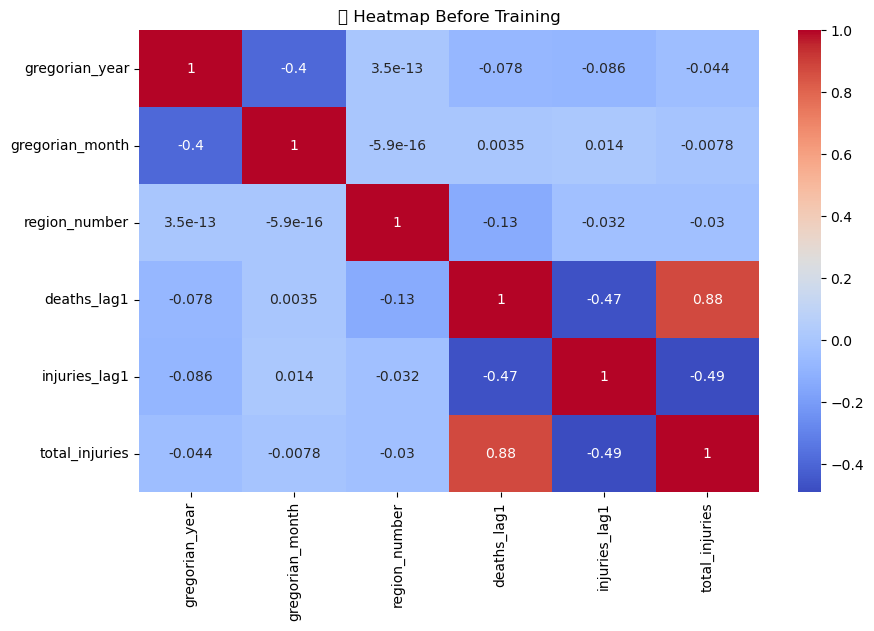

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 1136, number of used features: 5
[LightGBM] [Info] Start training from score 86.570423

Best Params: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 15}

🔷 LightGBM Time-Series Cross-Validation Results
MAE: 12.09
RMSE: 23.83
R²: 0.96

Sample Predictions:
   gregorian_year  gregorian_month  region_number  deaths_lag1  injuries_lag1  \
0            2015               10              1          0.0          310.0   
1            2015               11              1         97.0            0.0   
2            2015               11              1          0.0          338.0   
3            2015               12              1        102.0            0.0   
4            2015               12              1          

C:\Users\Fatimah\AppData\Local\Temp\ipykernel_17288\2330407696.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


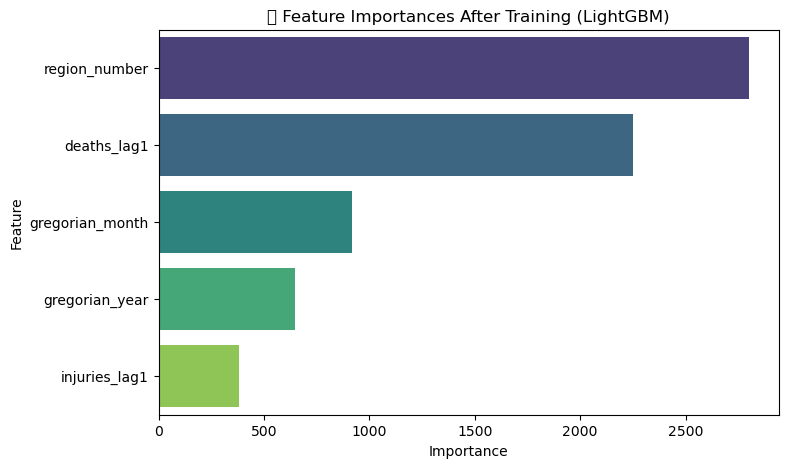

In [6]:
# ==============================================================
# ✅ 1. Import Libraries
# ==============================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================================================
# ✅ 2. Load Data (Assuming df_model is pre-loaded)
# ==============================================================
# df_model = pd.read_csv('your_cleaned_data.csv') # Uncomment if needed

# Define features and target
features = ['gregorian_year', 'gregorian_month', 'region_number', 'deaths_lag1', 'injuries_lag1']
target = 'total_injuries' 

X = df_model[features]
y = df_model[target]

# ==============================================================
# ✅ 3. Heatmap Before Training
# ==============================================================
plt.figure(figsize=(10,6))
sns.heatmap(df_model[features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title('🔷 Heatmap Before Training')
plt.show()

# ==============================================================
# ✅ 4. Time Series Cross-Validation & Hyperparameter Tuning (No Early Stopping)
# ==============================================================
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [500, 1000],
    'max_depth': [-1, 5, 10]
}

model = LGBMRegressor(objective='regression')

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid.fit(X, y)

# ==============================================================
# ✅ 5. Evaluate Best Model
# ==============================================================
best_model = grid.best_estimator_
print(f"\nBest Params: {grid.best_params_}")

# Predict on full data (or do train-test split for true evaluation)
y_pred = best_model.predict(X)

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("\n🔷 LightGBM Time-Series Cross-Validation Results")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# ==============================================================
# ✅ 6. Sample Predictions
# ==============================================================
results_df = X.copy()
results_df['Actual'] = y
results_df['Predicted'] = y_pred

print("\nSample Predictions:")
print(results_df.head(10))

# ==============================================================
# ✅ 7. Feature Importance Heatmap After Training
# ==============================================================
feat_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')
plt.title('🔷 Feature Importances After Training (LightGBM)')
plt.show()


In [7]:
print("\n🔷 LightGBM Time-Series Cross-Validation Results")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# ==============================================================
# ✅ 6. Sample Predictions
# ==============================================================
 

print("\nSample Predictions:")
print(results_df.head(10))


🔷 LightGBM Time-Series Cross-Validation Results
MAE: 12.09
RMSE: 23.83
R²: 0.96

Sample Predictions:
   gregorian_year  gregorian_month  region_number  deaths_lag1  injuries_lag1  \
0            2015               10              1          0.0          310.0   
1            2015               11              1         97.0            0.0   
2            2015               11              1          0.0          338.0   
3            2015               12              1        102.0            0.0   
4            2015               12              1          0.0          333.0   
5            2016                1              1        103.0            0.0   
6            2016                1              1          0.0          339.0   
7            2016                2              1        126.0            0.0   
8            2016                2              1          0.0          323.0   
9            2016                3              1         93.0            0.0   

   Act